In [13]:
%run utils

pandas version  2.2.2


In [14]:
#dL=0.044;  # position offset between sensors along z axis for WALKMAN feet
#dL=0.0346; # position offset between sensors along z axis for mini45/50 sensors 
#dL=0.1737; # New setup distance from from mini 45 ATI to the foot sensor.
#dL=0.065;  # New setup distance from from mini 45 ATI to the HERI hand sensor.
#dL=0.159;  # New setup distance from from mini 45 ATI to the cogimon foot sensor.
#dL=0.0549; # New setup distance from from mini 45 ATI to the HERI hand sensor for Singapore.
dL=0.04 + 0.0157 # height of metal part + height of the ATI sensor body

In [15]:
dt_str = datetime.datetime.now().strftime("%y-%m-%d_%H:%M:%S")
fdate = 'sens_{}.txt'.format(dt_str)
os.rename('sens.txt',fdate)

In [24]:
raw_col_names = [f'raw_{i}' for i in range(1,7)] 
ft_cols_name = str.split("fx fy fz tx ty tz")
ati_col_names = [f'ati_{s}' for s in ft_cols_name]
cal_col_names = [f'cal_{s}' for s in ft_cols_name]

col_names =["time_ns"]+raw_col_names+ati_col_names
# read local file
#file = 'sens_23-03-07_14:09:29.txt'
file = fdate
data = pd.read_csv(file, sep="\t", names=col_names)
# read from gitlab
gitlab_file_arg = ("hhmc-firmware/msp432-ft6","calib/sens_1.txt","calib")
#data = pd.read_csv(gitlab_raw_data(*gitlab_file_arg), sep="\t", names=col_names)
# read from github
url = 'https://github.com/alessiomargan/pandas-snip/raw/main/sens_ones_2.txt'
#data = pd.read_csv(file, sep="\t", names=col_names)

#data = pd.DataFrame(np.arange(20).reshape(10,2))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129488 entries, 0 to 129487
Data columns (total 13 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   time_ns  129488 non-null  int64  
 1   raw_1    129488 non-null  float64
 2   raw_2    129488 non-null  float64
 3   raw_3    129488 non-null  float64
 4   raw_4    129488 non-null  float64
 5   raw_5    129488 non-null  float64
 6   raw_6    129488 non-null  float64
 7   ati_fx   129488 non-null  float64
 8   ati_fy   129488 non-null  float64
 9   ati_fz   129488 non-null  float64
 10  ati_tx   129488 non-null  float64
 11  ati_ty   129488 non-null  float64
 12  ati_tz   129488 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 12.8 MB


Prepare data
- SG{i,v} ==> Strain Gauge raw data (sg1, sg2, sg3, sg4, sg5, sg6)
- SGi used for identification of calib matrix, first half samples
- SGv used for verification of calib matrix, seconda half samples
- FT{i,v} ==> ATI Force Torque data (fx, fy, fz, tx, ty, tz)
- FTi used for identification of calib matrix
- FTv used for verification of calib matrix

In [25]:
ign = 10000
drop_idx = True
half_idx = math.ceil(len(data)/2)
_1st_half = data[ign:half_idx]
_2nd_half = data[ign+half_idx:len(data)]
SG = data[raw_col_names].copy().reset_index(drop=drop_idx)
SGi = _1st_half[raw_col_names].copy().reset_index(drop=drop_idx)
SGv = _2nd_half[raw_col_names].copy().reset_index(drop=drop_idx)
FTi = _1st_half[ati_col_names].copy().reset_index(drop=drop_idx)
FTv = _2nd_half[ati_col_names].copy().reset_index(drop=drop_idx)
# Map measured ATI Tx,Ty to our sensor frame at distance dL along z axis
# correct Tx torque for the dL    Tx_IIT = Tx_ATI-Fy_ATI*DL
FTi.ati_tx -= FTi.ati_fy*dL
# correct Ty torque for the dL    Ty_IIT = Ty_ATI+Fx_ATI*DL
FTi.ati_ty += FTi.ati_fx*dL
# correct Tx torque for the dL    Tx_IIT = Tx_ATI-Fy_ATI*DL
FTv.ati_tx -= FTv.ati_fy*dL
# correct Ty torque for the dL    Ty_IIT = Ty_ATI+Fx_ATI*DL
FTv.ati_ty += FTv.ati_fx*dL

# from DataFrame to numpy matrix
npSG = SG.to_numpy()
npSGi = SGi.to_numpy()
npSGv = SGv.to_numpy()
npFTi = FTi.to_numpy()

npSGi_inv = np.linalg.pinv(npSGi)
npCM = np.dot(npSGi_inv,npFTi)
condCM = np.linalg.cond(npCM)
print(f"CM condition number {condCM}")

Fc = pd.DataFrame(data=np.dot(npSGv,npCM),columns=cal_col_names)

data = data.join(pd.DataFrame(data=np.dot(npSG,npCM).astype(float),columns=cal_col_names))

data["err_fx"] = data["ati_fx"] - data["cal_fx"]
data["err_fy"] = data["ati_fy"] - data["cal_fy"]
data["err_fz"] = data["ati_fz"] - data["cal_fz"]

# Compute mean square errors
F_residual = Fc - FTv



CM condition number 114.52773430094393


In [26]:
ret = write_bin(np.identity(6),"ones.bin")
ret = write_bin(npCM.T,"cal_mat.bin")
ret = write_bin(npCM.T,"cal_mat_{}.bin".format(dt_str))


True
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
m shape (6, 6) (6, 6)
m bytes 144
False
[[ 2.29971899e+03 -9.13685894e+00 -5.19614410e+01 -1.19601612e+01
  -2.35898291e+03 -1.95843277e+02]
 [ 2.74599219e+03  1.50357605e+02 -2.79395508e+03  8.08780060e+01
  -1.21000725e+02 -1.03138023e+02]
 [-4.93826447e+02 -1.65681262e+03 -5.81852646e+01 -1.72641162e+03
   5.91765442e+02 -1.70368030e+03]
 [ 2.31883850e+01 -2.64717216e+01 -3.29231834e+01  1.02597439e+00
   9.31296062e+00  2.82937164e+01]
 [-7.29516315e+00 -1.58447390e+01  3.84417319e+00  3.53990097e+01
   3.00065660e+00 -1.41572227e+01]
 [-6.15552044e+00  2.97922087e+00 -2.80943527e+01  6.10335350e-01
  -5.86829643e+01 -4.18095207e+00]]
m shape (6, 6) (6, 6)
m bytes 144


<Axes: >

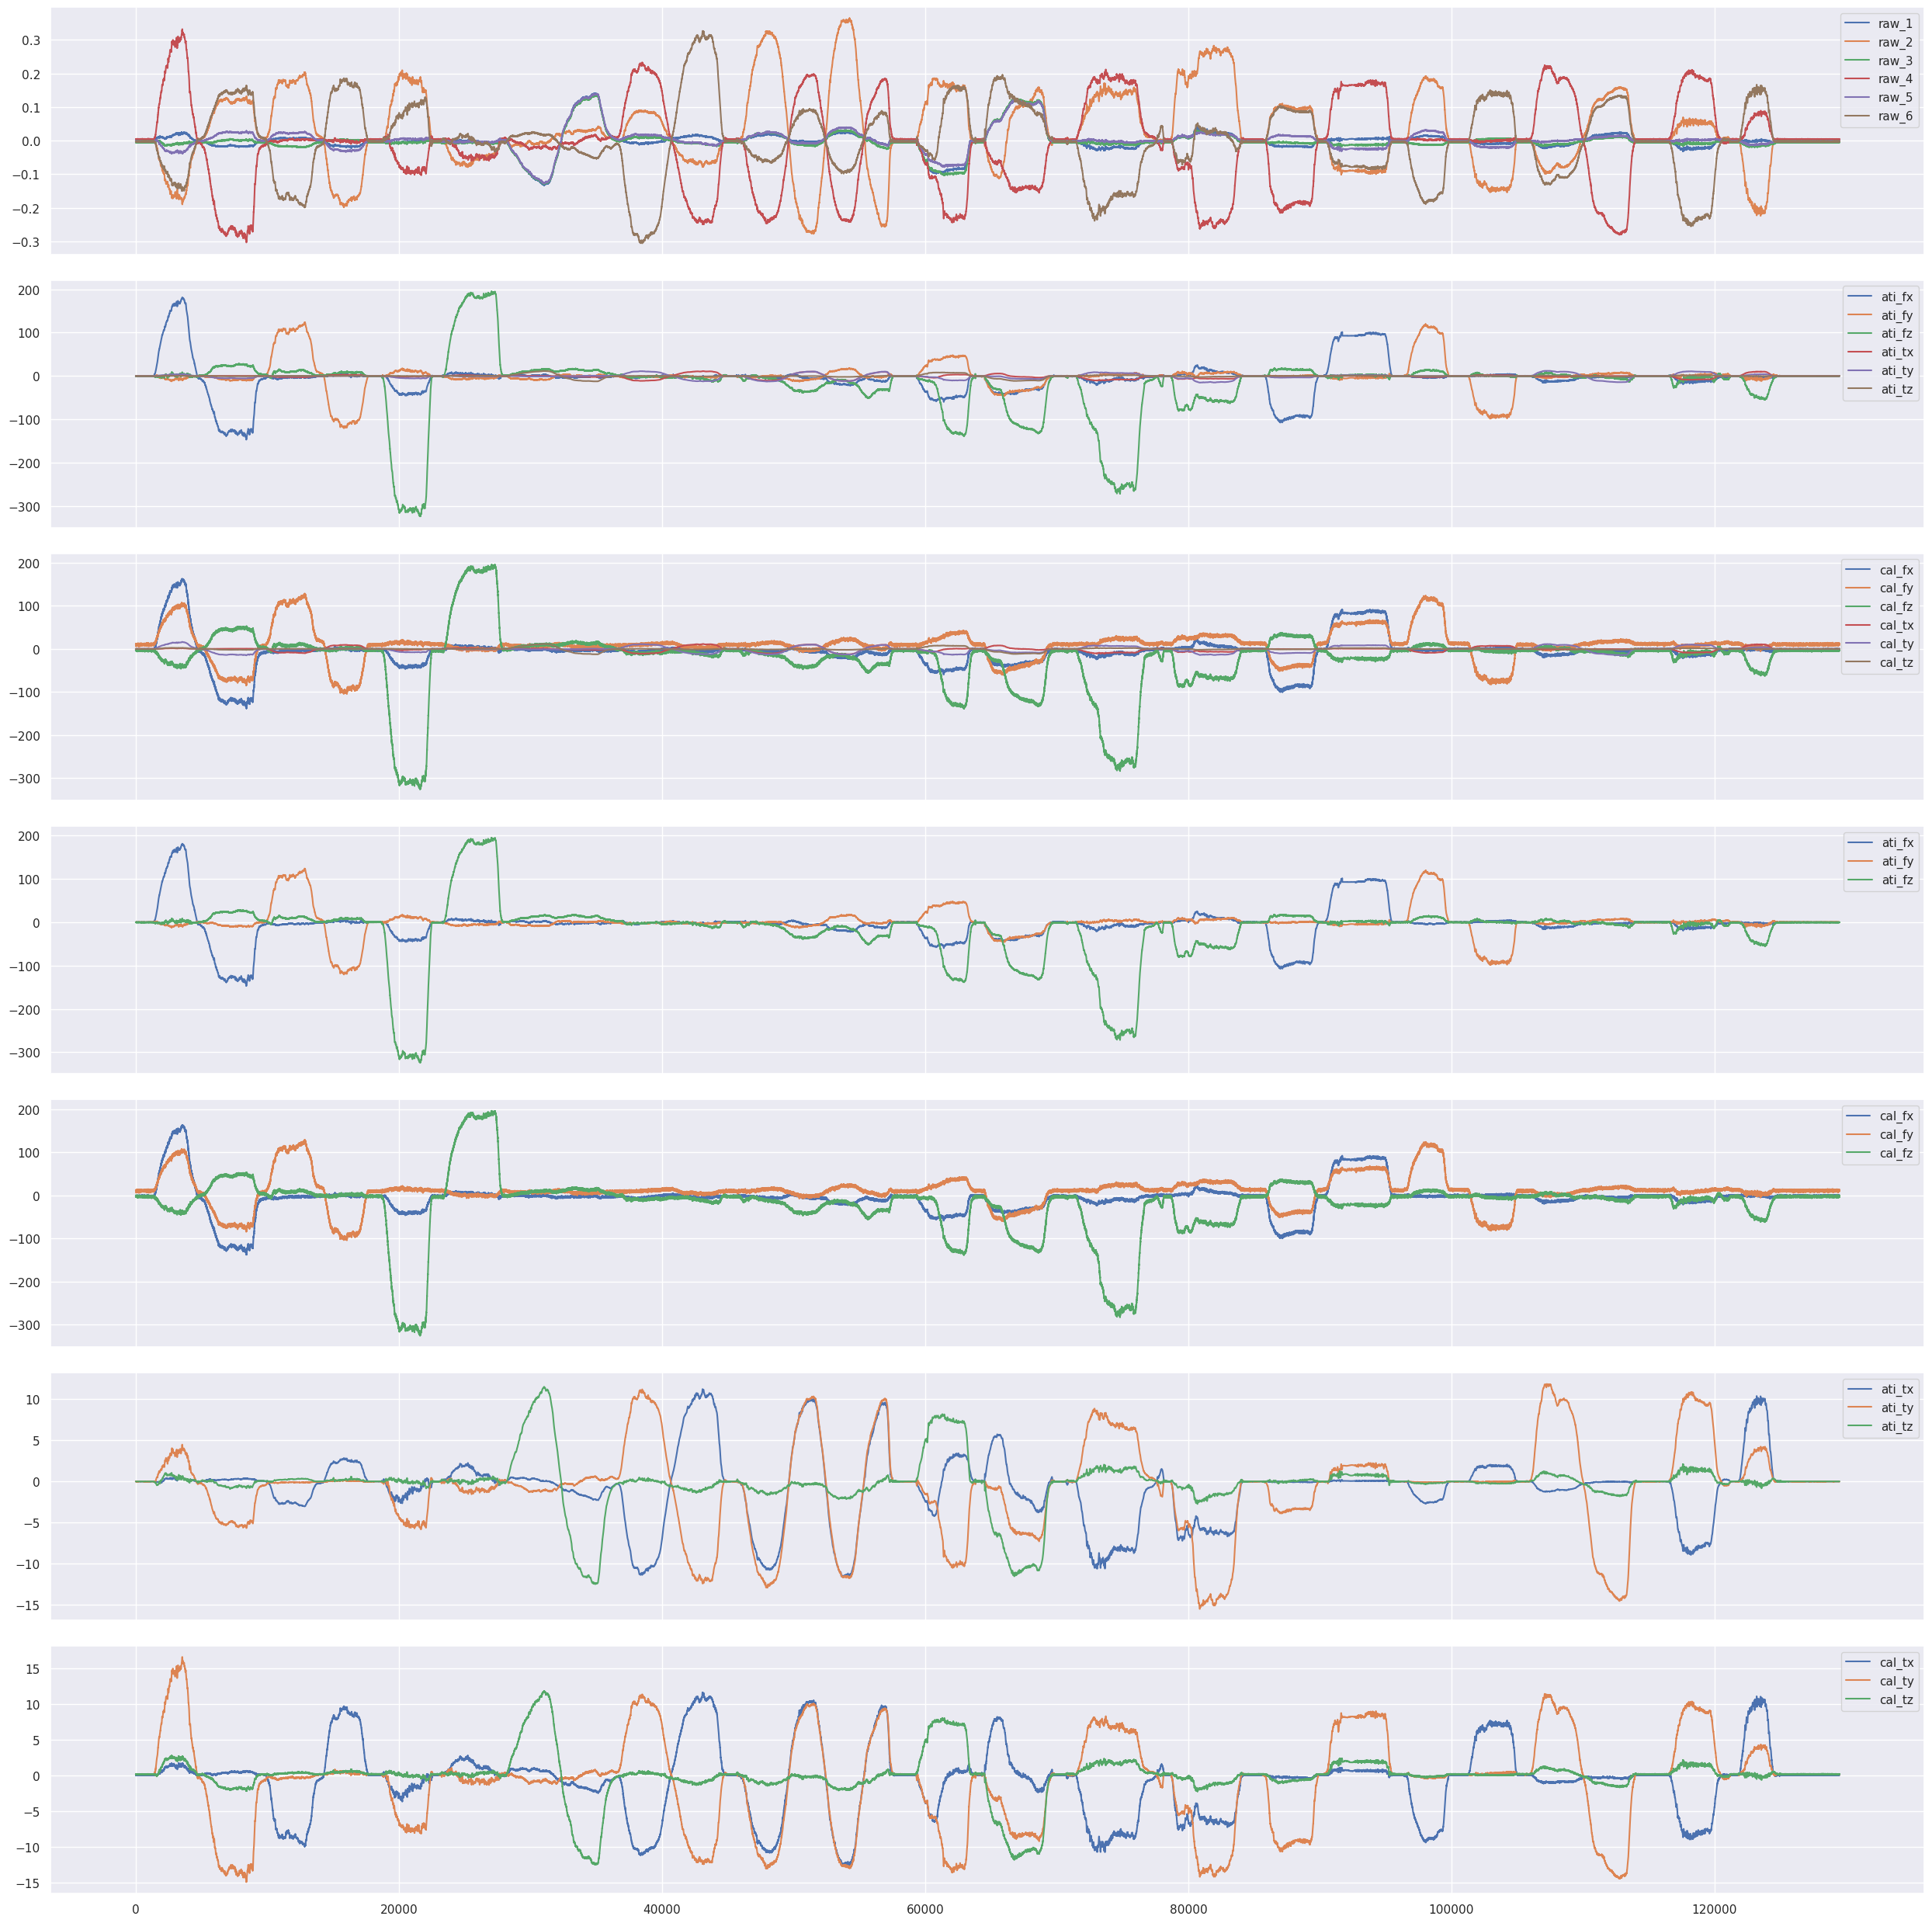

In [27]:

fig, axes = plt.subplots(7,1, sharex='col', figsize=(25,25))
plt.tight_layout()

#data[col_names[1:]].plot(ax=axes[0,0])
data[raw_col_names].plot(ax=axes[0])
data[ati_col_names].plot(ax=axes[1])
data[cal_col_names].plot(ax=axes[2])
#data[raw_col_names[:3]].plot(ax=axes[3])
data[ati_col_names[:3]].plot(ax=axes[3])
data[cal_col_names[:3]].plot(ax=axes[4])
#data[raw_col_names[-3:]].plot(ax=axes[5])
data[ati_col_names[-3:]].plot(ax=axes[5])
data[cal_col_names[-3:]].plot(ax=axes[6])


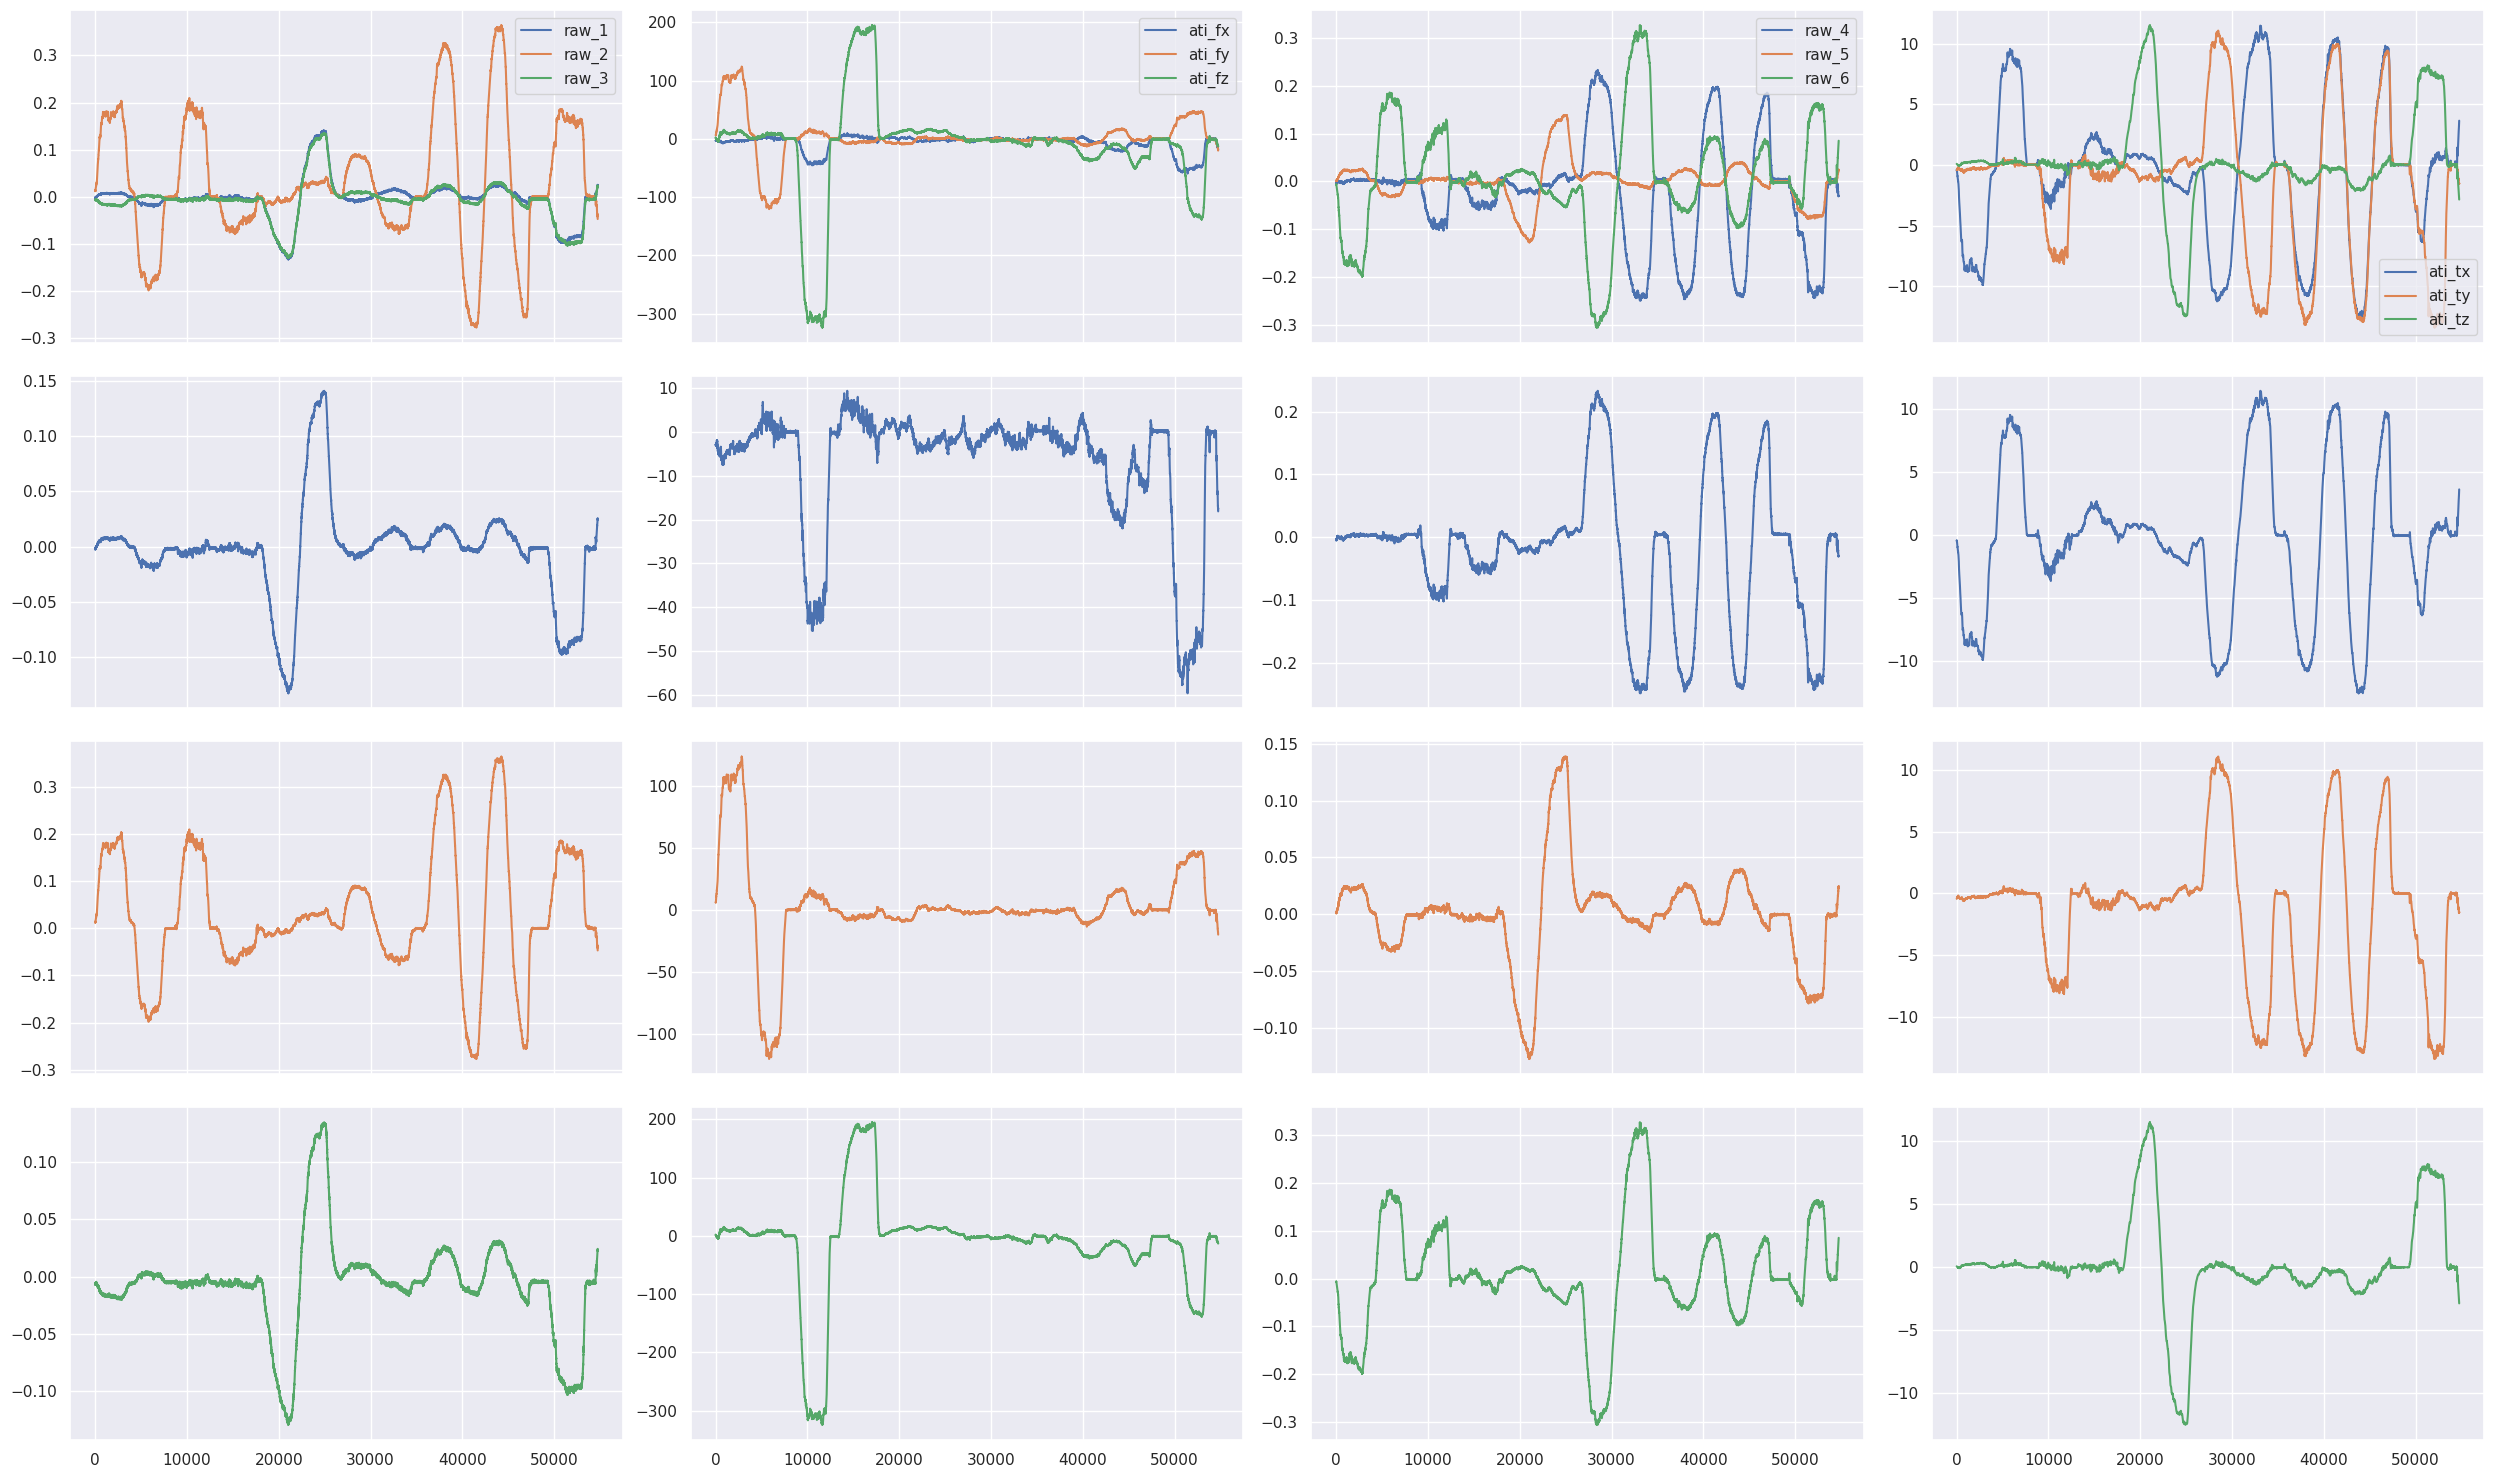

In [28]:
fig, axes = plt.subplots(4,4, sharex='col', figsize=(25,15))
plt.tight_layout()
#https://matplotlib.org/stable/users/dflt_style_changes.html
colors = list(map(lambda x:'C'+str(x),range(10))) 
colors = [f'C{i}' for i in range(10)] 

def plot_data(ax, df, col_names, sub_col):
    df[col_names].plot(ax=axes[0,sub_col])
    for i,c in enumerate(col_names,start=1) :
        df[c].plot(ax=ax[i,sub_col],color=colors[i-1], label=c)
     
plot_data(axes, SGi, raw_col_names[:3],  0)
plot_data(axes, FTi, ati_col_names[:3], 1)
plot_data(axes, SGi, raw_col_names[-3:], 2)
plot_data(axes, FTi, ati_col_names[-3:], 3)

#plot_data(axes, F_residual, ft_col_names[:3], 2)
#plot_data(axes, F_residual, ft_col_names[-3:], 4)


<Axes: >

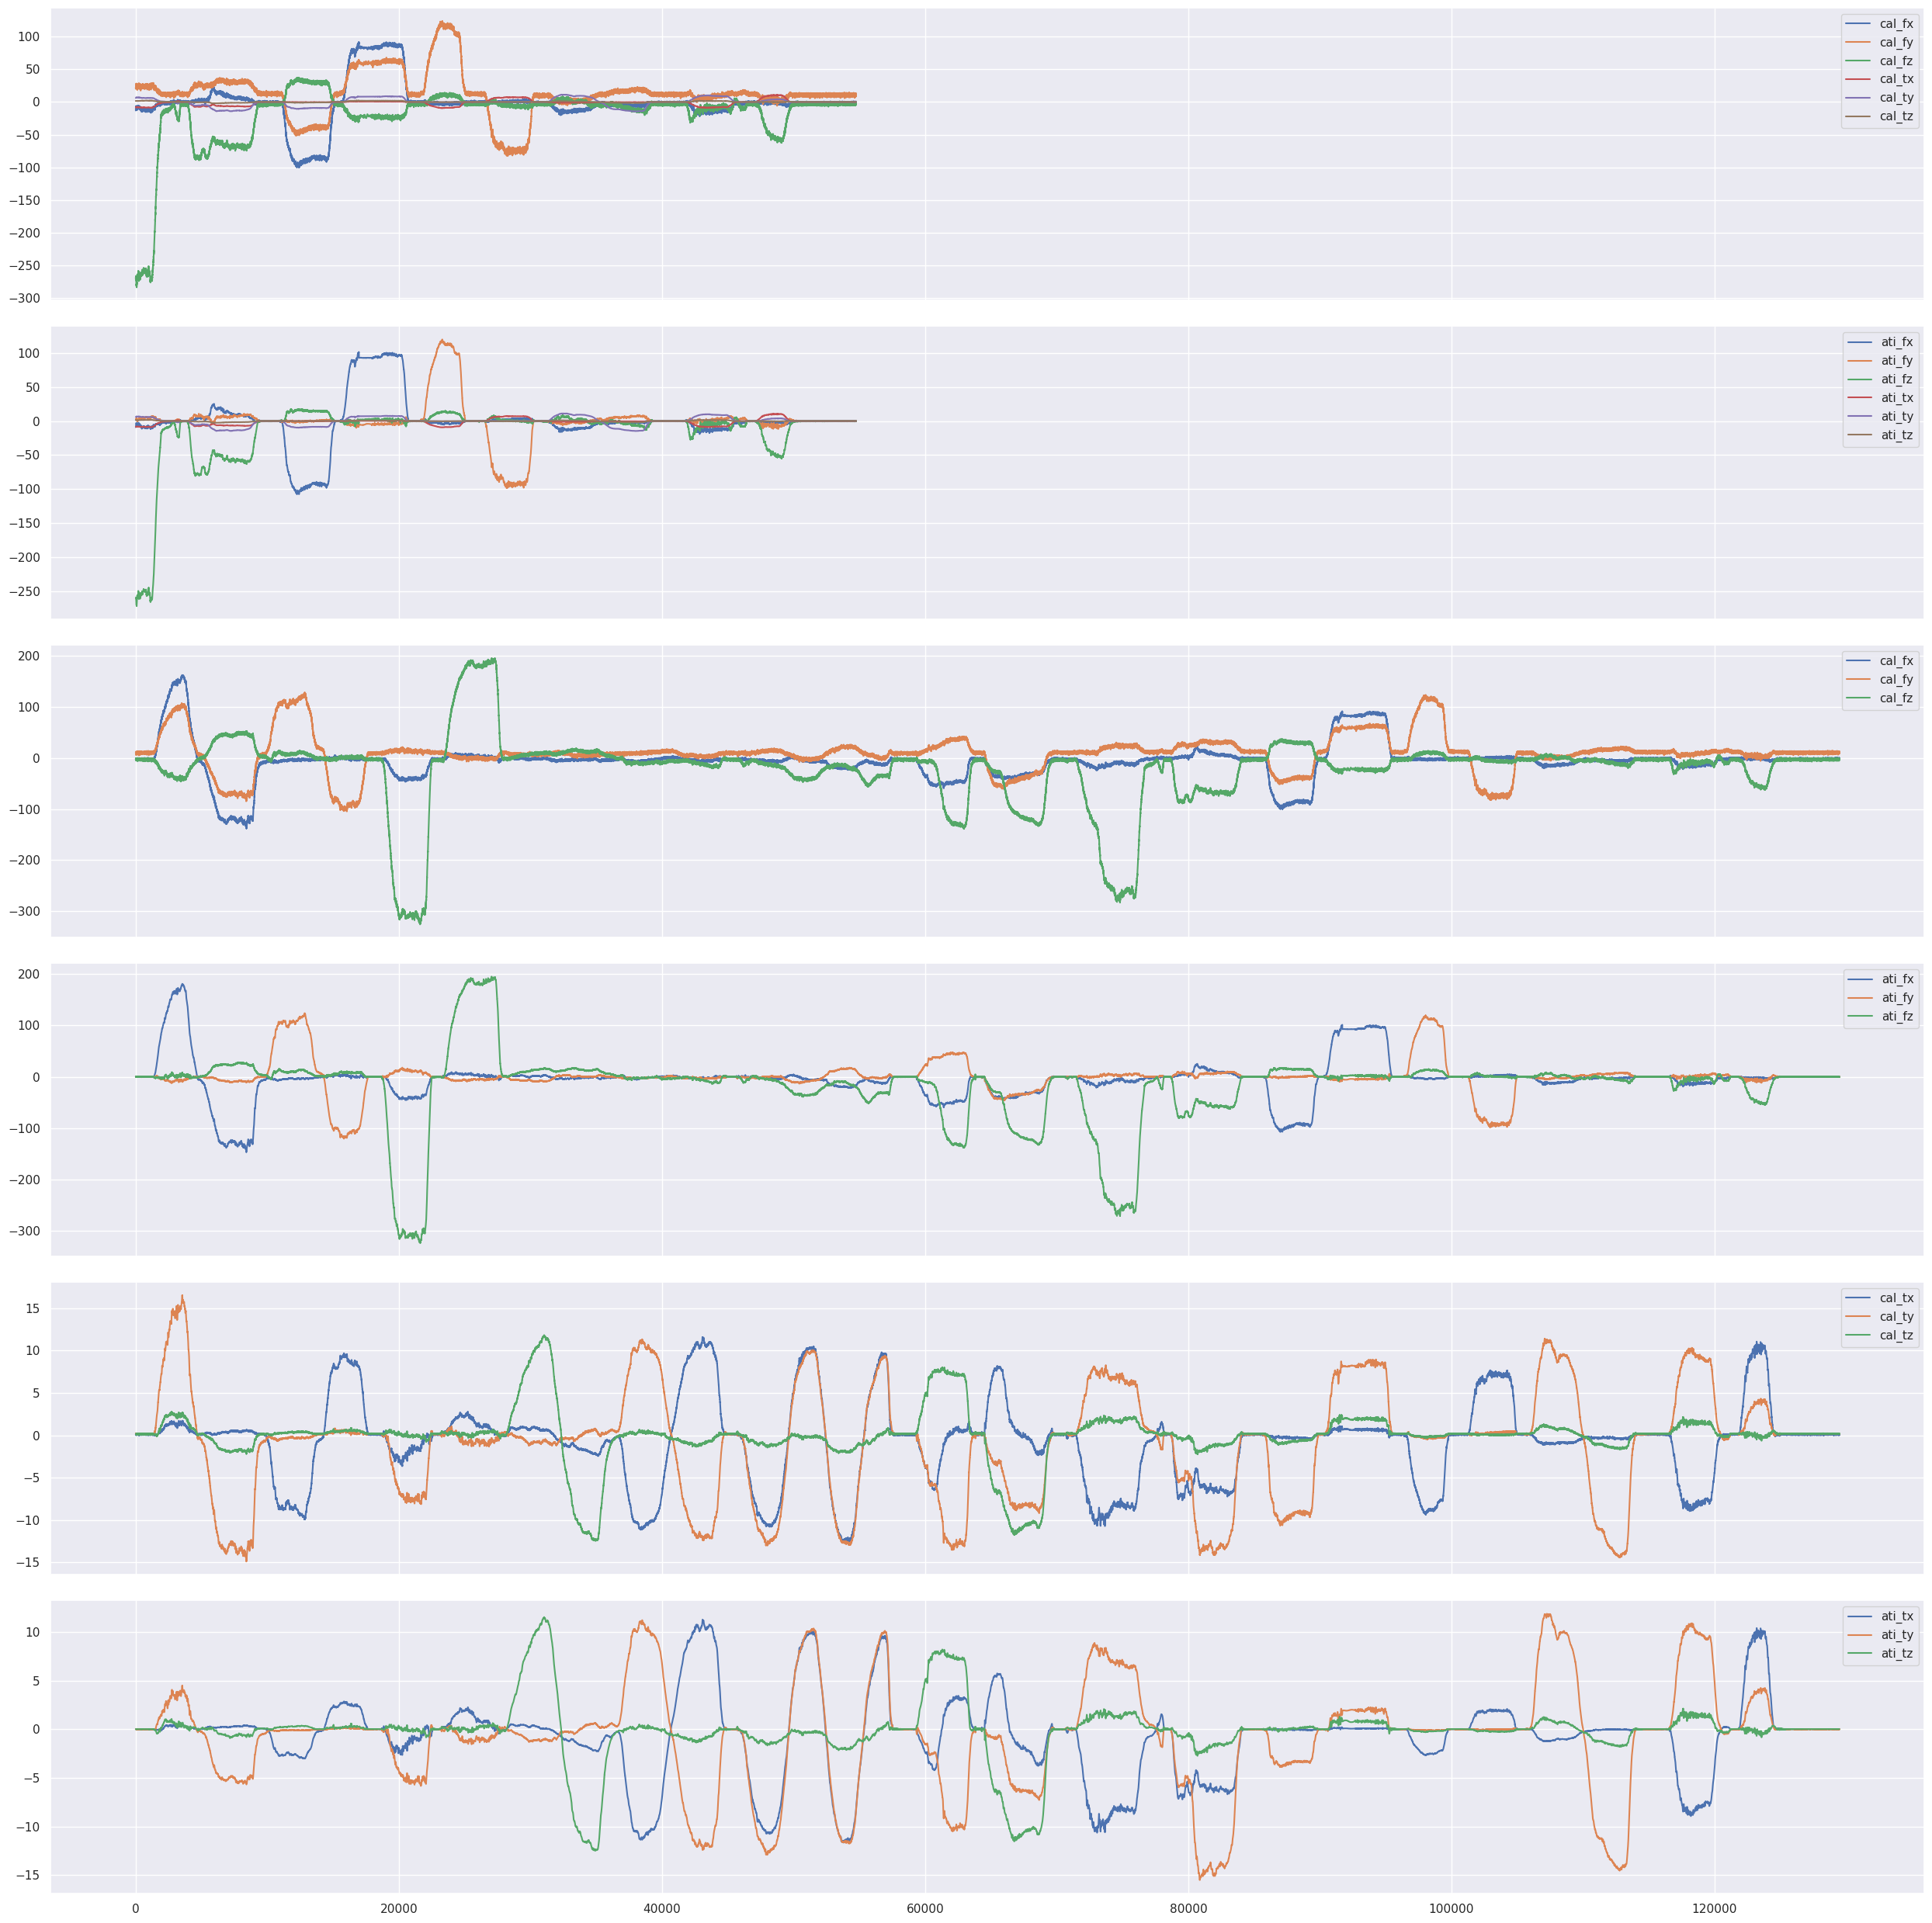

In [29]:
fig, axes = plt.subplots(6,1, sharex='col', figsize=(25,25))
plt.tight_layout()

Fc.plot(ax=axes[0])
FTv.plot(ax=axes[1])
data[cal_col_names[:3]].plot(ax=axes[2])
data[ati_col_names[:3]].plot(ax=axes[3])
data[cal_col_names[-3:]].plot(ax=axes[4])
data[ati_col_names[-3:]].plot(ax=axes[5])


<Axes: >

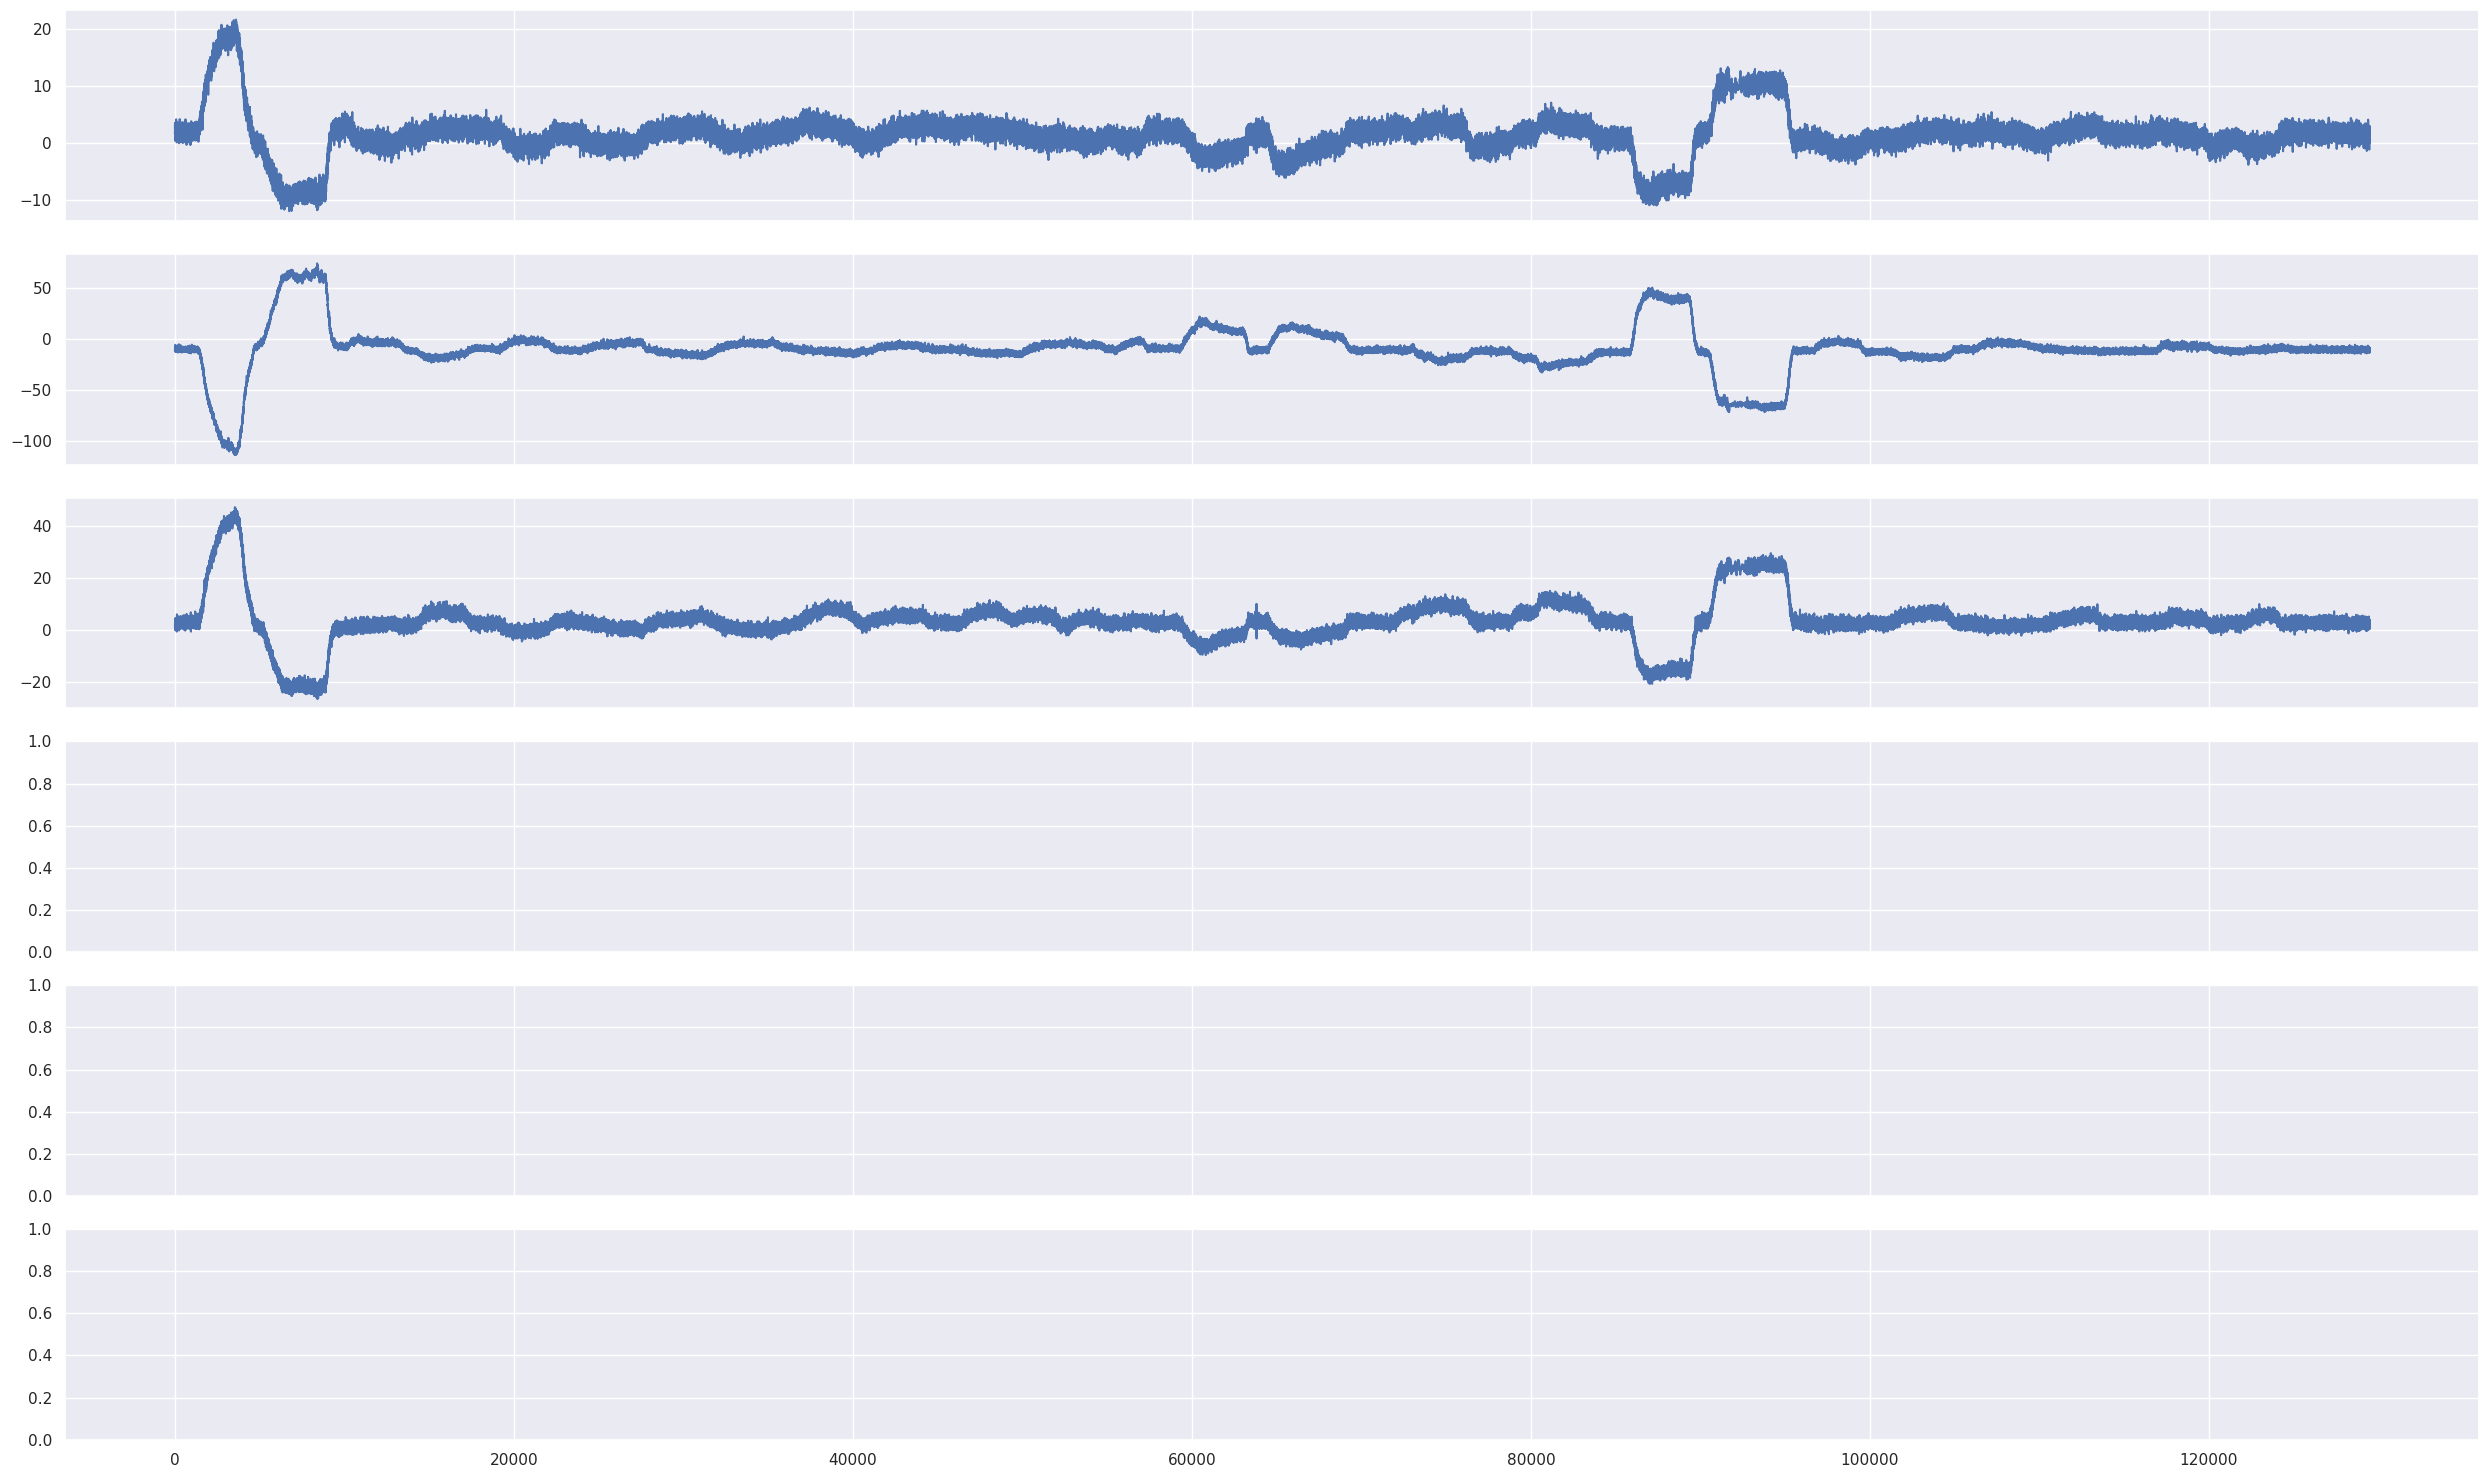

In [30]:
fig, axes = plt.subplots(6,1, sharex='col', figsize=(25,15))
plt.tight_layout()

#F_residual.fx.plot(kind='hist',bins=100)
data["err_fx"].plot(ax=axes[0])
data["err_fy"].plot(ax=axes[1])
data["err_fz"].plot(ax=axes[2])

<Axes: >

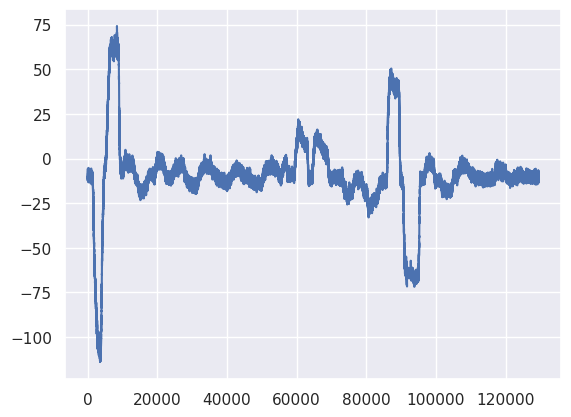

In [32]:
data["err_fy"].plot()

In [23]:
nikos = pd.read_csv('nikos.txt', sep=",", names=[f'col_{i}' for i in range(1,7)])
nikos.to_numpy()

array([[-2.88019914e+03,  1.52355729e+03,  7.55339433e+02,
         1.99114031e+01,  3.26667459e+01, -3.82843527e+01],
       [-9.09756440e+00, -2.34423077e+02, -1.96104940e+03,
         3.14277283e+01, -1.86352446e+01,  5.74464127e-01],
       [ 2.89611223e+03,  1.87277050e+03, -2.67520120e+02,
         2.02795891e+01, -3.31396205e+01, -3.54236001e+01],
       [ 1.53970859e+02,  1.91797189e+02, -1.91724935e+03,
        -3.16042499e+01, -2.01853775e+01, -9.20282766e-01],
       [-1.04051761e+02, -3.40817752e+03, -4.92316855e+02,
        -4.08567371e+01,  8.95866703e-01, -3.60963878e+01],
       [ 1.88197986e+02, -9.98938486e+01, -1.90920569e+03,
         2.32284625e-01,  3.63886385e+01, -2.04869614e+00]])

In [ ]:
ret = write_bin(nikos.to_numpy(),"cal_mat.bin")